# Roofline experiments

We'll investigate the cross-over point from memory bandwidth bound to compute
bound for vector and matrix operations on Cloud TPU.

In [1]:
import torch
import torch_xla
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

from dataclasses import dataclass


@dataclass
class Spec:
  mxu_flops: int
  """BF16 flops per second per chip."""

  hbm_bandwidth: int
  """HBM bandwidth in bytes per second."""
  
  def arithmetic_intensity(self):
    """Arithmetic intensity in FLOPS/byte."""
    return self.mxu_flops / self.hbm_bandwidth
  

T = 1e12  # Tera

TPU_SPEC = {
  "v4": Spec(
    mxu_flops=275 * T,
    hbm_bandwidth=int(1.2 * T),
  ),
  "v5litepod": Spec(
    mxu_flops=197 * T,
    hbm_bandwidth=int(0.819 * T),
  ),
  "v6e": Spec(
    mxu_flops=918 * T,
    hbm_bandwidth=int(1.64 * T),
  ),
}

tpu_spec = TPU_SPEC[torch_xla.tpu.get_tpu_type()]

## Vector roofline

In [2]:
from functools import reduce
import time
import numpy as np
import torch_xla.core.xla_model as xm


@dataclass
class BenchmarkResult:
  flops: float
  """Number of floating point operations per second."""
  
  arithmetic_intensity: float
  """Number of floating point operations done per byte transferred (FLOPS/byte)."""
  
  @property
  def tflops(self):
    """Number of tera floating point operations per second."""
    return self.flops / 1e12

  def __str__(self):
    return f"{self.tflops:.4f} TFLOP/s, {self.arithmetic_intensity:.4f} FLOPS/byte"


def run_ops(operands, num_operations):
  match num_operations:
    case 1:
      # Benchmark N-1 sums
      return sum(operands)
    case 2:
      # Benchmark N-1 sums and N-1 multiplications and one final sum
      return run_ops(operands, num_operations-1) + reduce(lambda x, y: x * y, operands)
    case 3:
      # Benchmark N-1 sums and N-1 multiplications and N-1 subtractions and two final sums
      return run_ops(operands, num_operations-1) + reduce(lambda x, y: x - y, operands)
    case 4:
      # Benchmark N-1 sums and N-1 multiplications and N-1 subtractions and N-1 divisions and three final sums
      return run_ops(operands, num_operations-1) + reduce(lambda x, y: x / y, operands)
    case 5:
      # Benchmark N-1 sums and N-1 multiplications and N-1 subtractions and N-1 divisions and N-1 clamp-min and four final sums
      return run_ops(operands, num_operations-1) + reduce(lambda x, y: torch.clamp(x, min=y), operands)
    case 6:
      # Benchmark N-1 sums and N-1 multiplications and N-1 subtractions and N-1 divisions and N-1 clamp-min and N-1 clamp-max and five final sums
      return run_ops(operands, num_operations-1) + reduce(lambda x, y: torch.clamp(x, max=y), operands)
    case _:
      return run_ops(operands, num_operations-1) + run_ops([torch.clamp(o, min=-float(num_operations)) for o in operands], num_operations-6)


def measure_vector_flops(num_operands: int, num_operations: int):
  NUM_ITERS = 100
  SIZE = 16384
  operands = []
  for _ in range(num_operands):
    operands.append(torch.randn(SIZE, SIZE, dtype=torch.bfloat16, requires_grad=False, device=xm.xla_device()))
    torch_xla.sync()
  # Measure in a loop
  times = []

  def count_flops(num_operands, num_operations):
    if num_operations <= 6:
      return SIZE * SIZE * (num_operands - 1) * num_operations + ((SIZE * SIZE) * (num_operations - 1))
    else:
      return count_flops(num_operands, num_operations-1) + count_flops(num_operands, num_operations-6) + (SIZE * SIZE) + ((SIZE * SIZE) * num_operands)

  for i in range(NUM_ITERS):
    torch_xla.sync(wait=True)
    result = run_ops(operands, num_operations)
    start = time.time()
    torch_xla.sync()
    _ = xm.unlazy([result])
    end = time.time()
    times.append(end - start)
  run_time = float(np.median(times))
  flops = count_flops(num_operands, num_operations)
  bytes_transferred = SIZE * SIZE * (num_operands + 1) * 2  # 2 bytes per BF16
  arithmetic_intensity = flops / bytes_transferred
  return BenchmarkResult(
    flops=flops / run_time,
    arithmetic_intensity=arithmetic_intensity,
  )

In [3]:
import gc
vector_flops = {}
for num_operations in range(1, 16):
  for num_operands in range(2, 24):
    vector_flops[(num_operands, num_operations)] = measure_vector_flops(num_operands, num_operations)
    print(f"vector_flops[{num_operands}, {num_operations}] = {vector_flops[(num_operands, num_operations)]}")
    gc.collect()

vector_flops[2, 1] = 0.1140 TFLOP/s, 0.1667 FLOPS/byte
vector_flops[3, 1] = 0.1815 TFLOP/s, 0.2500 FLOPS/byte
vector_flops[4, 1] = 0.2193 TFLOP/s, 0.3000 FLOPS/byte
vector_flops[5, 1] = 0.2439 TFLOP/s, 0.3333 FLOPS/byte
vector_flops[6, 1] = 0.2645 TFLOP/s, 0.3571 FLOPS/byte
vector_flops[7, 1] = 0.2777 TFLOP/s, 0.3750 FLOPS/byte
vector_flops[8, 1] = 0.2917 TFLOP/s, 0.3889 FLOPS/byte
vector_flops[9, 1] = 0.2997 TFLOP/s, 0.4000 FLOPS/byte
vector_flops[10, 1] = 0.3073 TFLOP/s, 0.4091 FLOPS/byte
vector_flops[11, 1] = 0.3117 TFLOP/s, 0.4167 FLOPS/byte
vector_flops[12, 1] = 0.2941 TFLOP/s, 0.4231 FLOPS/byte
vector_flops[13, 1] = 0.3232 TFLOP/s, 0.4286 FLOPS/byte
vector_flops[14, 1] = 0.3277 TFLOP/s, 0.4333 FLOPS/byte
vector_flops[15, 1] = 0.3314 TFLOP/s, 0.4375 FLOPS/byte
vector_flops[16, 1] = 0.3348 TFLOP/s, 0.4412 FLOPS/byte
vector_flops[17, 1] = 0.3379 TFLOP/s, 0.4444 FLOPS/byte
vector_flops[18, 1] = 0.3403 TFLOP/s, 0.4474 FLOPS/byte
vector_flops[19, 1] = 0.3424 TFLOP/s, 0.4500 FLOPS/byte


Text(0.5, 1.0, 'Measured Vector processing FLOPS vs Arithmetic Intensity')

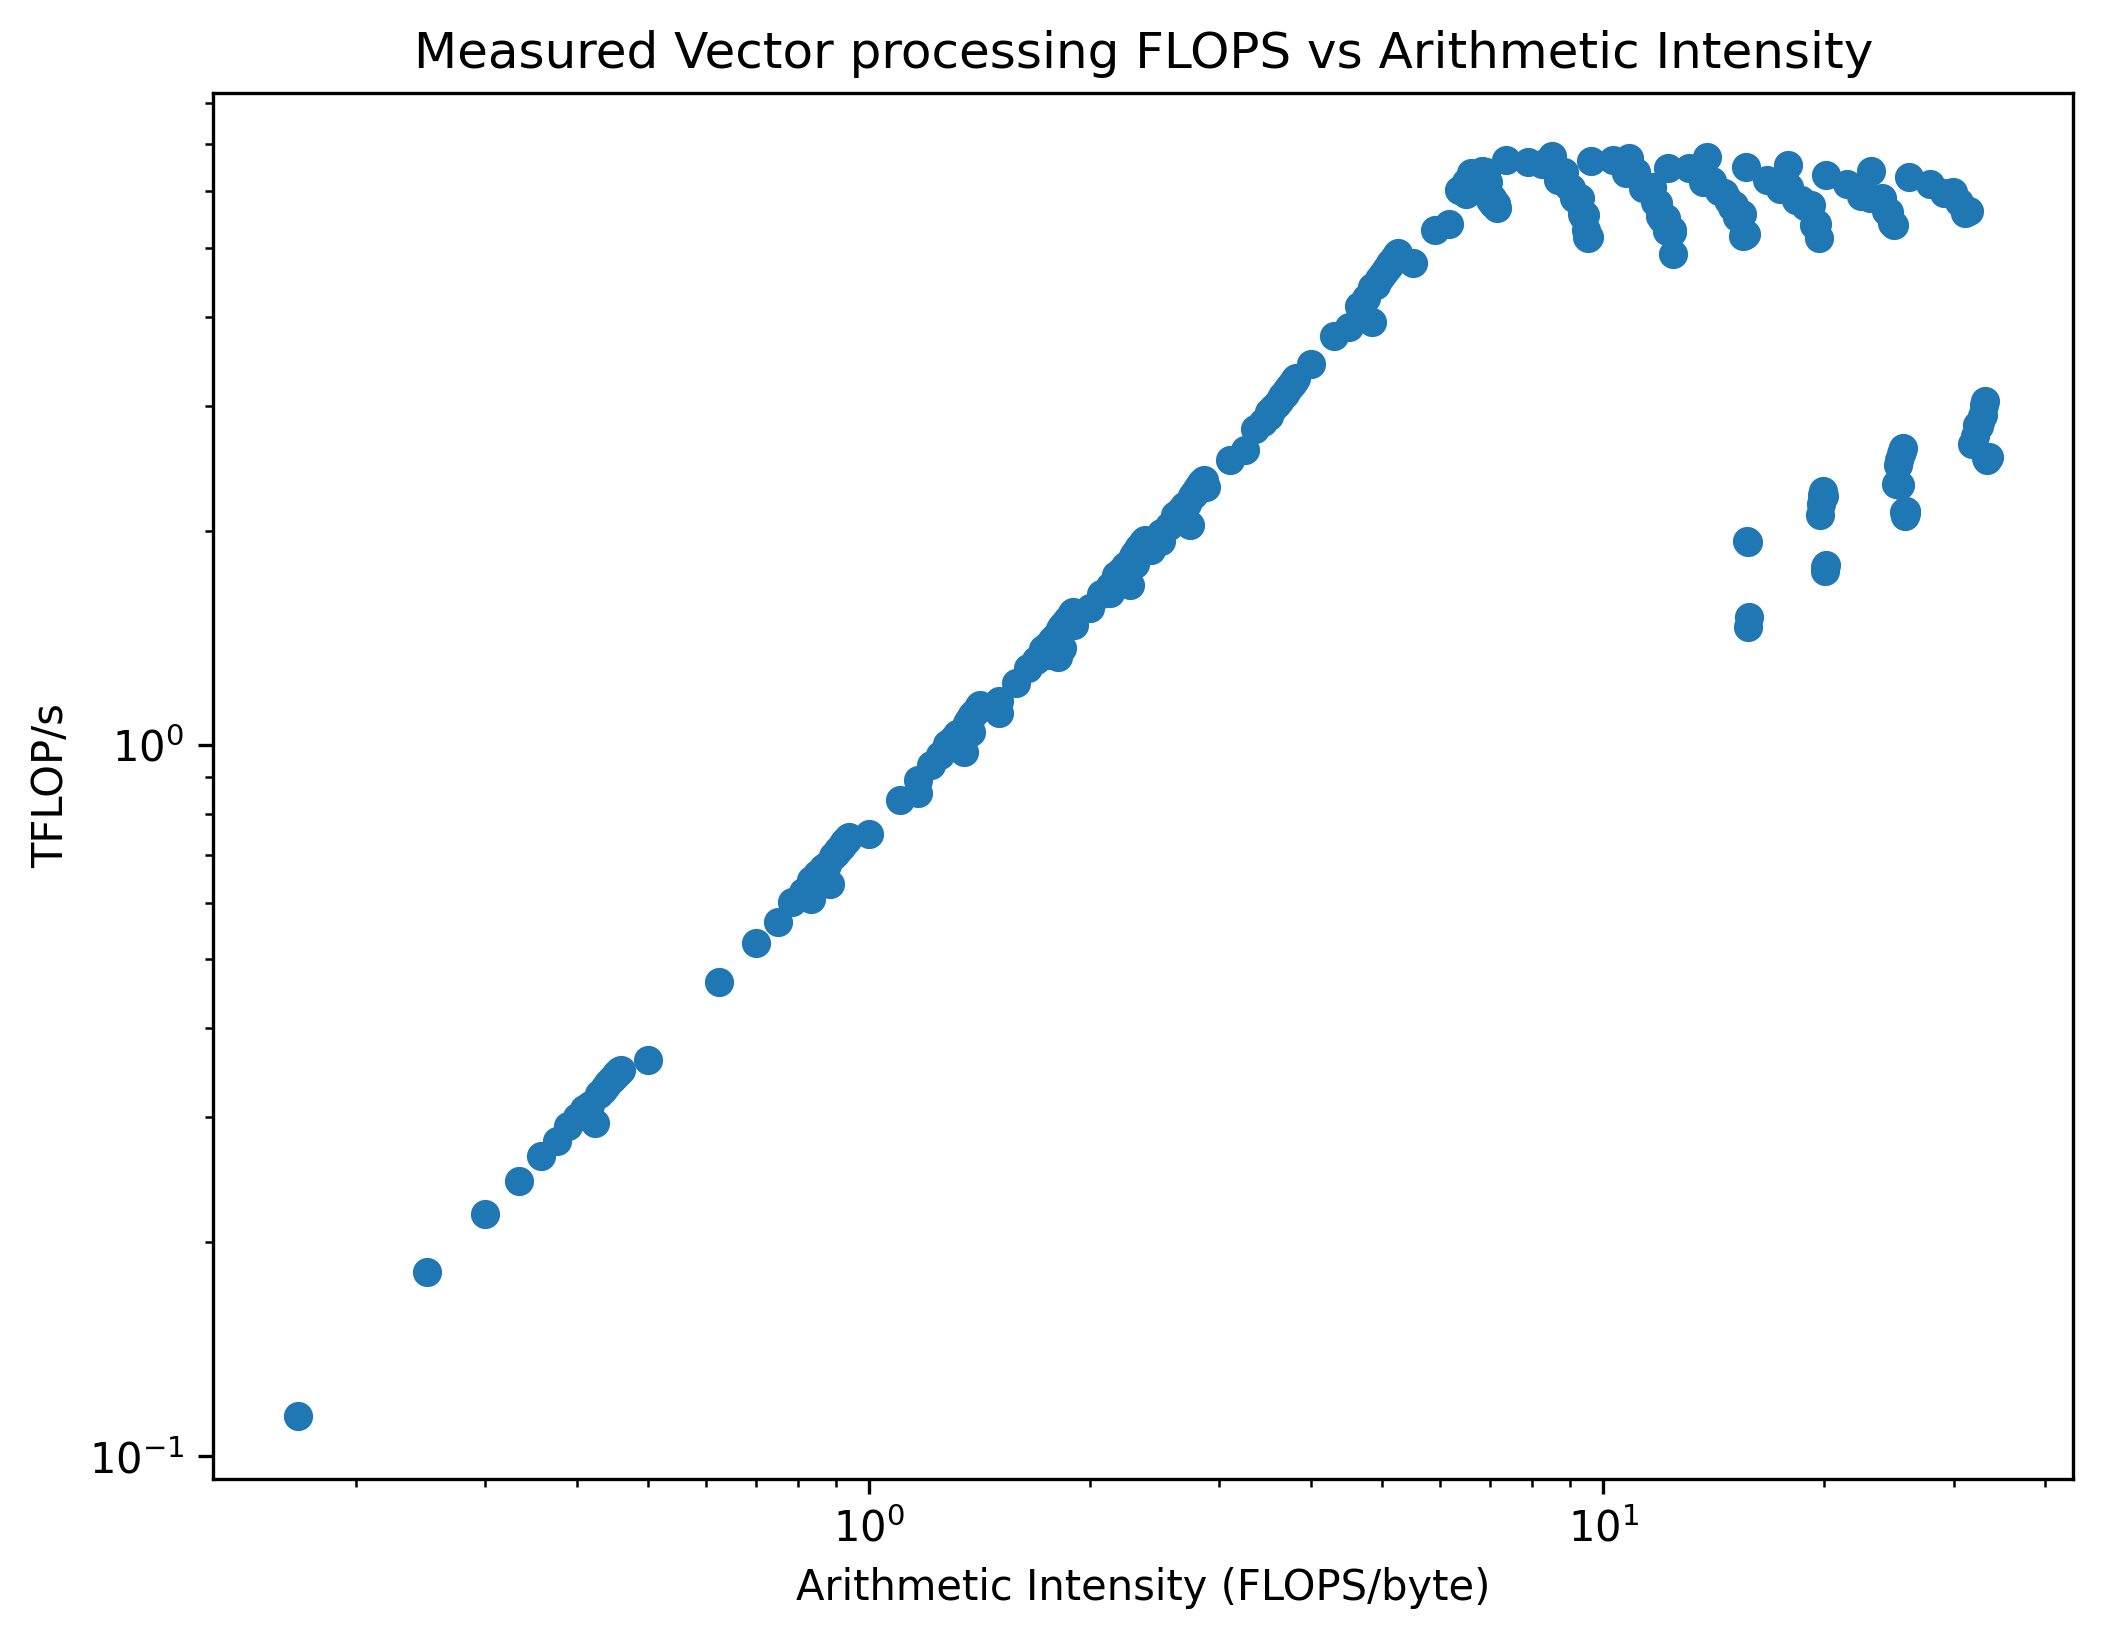

In [14]:
# Plot FLOPS against arithmetic intensity
plt.figure(figsize=(8, 6))
plt.scatter(
  [v.arithmetic_intensity for v in vector_flops.values()],
  [v.tflops for v in vector_flops.values()],
  label='Measured FLOPS',
)
plt.xlabel('Arithmetic Intensity (FLOPS/byte)')
plt.ylabel('TFLOP/s')
plt.xscale('log')
plt.yscale('log')
plt.title('Measured Vector processing FLOPS vs Arithmetic Intensity')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional


def estimate_roofline(
  arithmetic_intensities: List[float], tflops: List[float], plot: bool = True
) -> Tuple[Optional[float], Optional[float], Optional[float]]:
  """
  Estimates the Roofline model parameters (peak performance, memory bandwidth)
  from benchmark data points (arithmetic intensity, TFLOP/s).

  The function finds the upper envelope of the data and fits the two
  regimes (memory-bound and compute-bound) to this envelope.

  Args:
      arithmetic_intensities: A list of arithmetic intensity values (FLOP/byte).
      tflops: A list of corresponding performance values (TFLOP/s).
      plot: If True, generates a plot of the data, envelope, and fitted Roofline.

  Returns:
      A tuple containing:
      - peak_tflops (float): Estimated peak performance (TFLOP/s).
      - memory_bw (float): Estimated memory bandwidth (TB/s, derived from TFLOP/s / (FLOP/byte)).
      - ridge_point_ai (float): Estimated arithmetic intensity at the ridge point (FLOP/byte).
      Returns (None, None, None) if input is invalid or estimation fails.
  """
  if (
    not arithmetic_intensities
    or not tflops
    or len(arithmetic_intensities) != len(tflops)
  ):
    print("Error: Input lists are invalid or have different lengths.")
    return None, None, None

  # Convert to NumPy arrays and handle potential non-positive values for log plot
  ai = np.array(arithmetic_intensities)
  tf = np.array(tflops)

  # Remove invalid data points (e.g. non-positive AI or TFLOPs for log scale)
  valid_mask = (ai > 0) & (tf > 0)
  if not np.any(valid_mask):
    print("Error: No valid data points (AI > 0 and TFLOP/s > 0) found.")
    return None, None, None
  ai = ai[valid_mask]
  tf = tf[valid_mask]

  # Sort data points by arithmetic intensity
  sort_indices = np.argsort(ai)
  ai_sorted = ai[sort_indices]
  tf_sorted = tf[sort_indices]

  # --- Compute the upper envelope (Pareto frontier) ---
  envelope_ai = []
  envelope_tf = []
  max_tf_so_far = 0.0
  # Keep track of unique AI values in the envelope
  unique_ai_in_envelope = set()

  for i in range(len(ai_sorted)):
    # Update max TFLOPs seen so far
    if tf_sorted[i] > max_tf_so_far:
      max_tf_so_far = tf_sorted[i]

    # Add to envelope if it's a new AI or the highest TF for this AI
    current_ai = ai_sorted[i]
    if current_ai not in unique_ai_in_envelope:
      envelope_ai.append(current_ai)
      envelope_tf.append(max_tf_so_far)
      unique_ai_in_envelope.add(current_ai)
    elif max_tf_so_far > envelope_tf[-1]:
      # If same AI, update the TF if this point is higher
      # (Handles cases where points aren't strictly increasing in TF with AI)
      envelope_tf[-1] = max_tf_so_far

  if not envelope_ai:
    print("Error: Could not determine performance envelope.")
    return None, None, None

  envelope_ai = np.array(envelope_ai)
  envelope_tf = np.array(envelope_tf)

  # --- Estimate Compute Bound (Peak Performance) ---
  peak_tflops = np.max(envelope_tf)
  if peak_tflops <= 0:
    print("Error: Estimated peak TFLOP/s is not positive.")
    return None, None, None

  # Find the AI where the peak performance is first reached on the envelope
  # Use a small tolerance to handle potential floating point inaccuracies
  peak_indices = np.where(np.isclose(envelope_tf, peak_tflops))[0]
  if len(peak_indices) == 0:
    # Fallback if isclose fails somehow, though unlikely
    ai_at_peak = envelope_ai[np.argmax(envelope_tf)]
  else:
    ai_at_peak = envelope_ai[peak_indices[0]]

  # --- Estimate Memory Bound (Memory Bandwidth) ---
  # Select envelope points up to (and including) the point where peak performance is reached
  mem_bound_mask = envelope_ai <= ai_at_peak
  mem_bound_ai = envelope_ai[mem_bound_mask]
  mem_bound_tf = envelope_tf[mem_bound_mask]

  if len(mem_bound_ai) == 0:
    print("Warning: No points identified in the memory-bound region of the envelope.")
    # Cannot estimate bandwidth if no points are available
    memory_bw = None
    ridge_point_ai = None
  else:
    # Fit line TFLOPs = BW * AI through the origin (least squares solution)
    # BW = sum(ai * tf) / sum(ai^2)
    numerator = np.sum(mem_bound_ai * mem_bound_tf)
    denominator = np.sum(mem_bound_ai**2)

    if denominator <= 0:
      print(
        "Warning: Could not calculate memory bandwidth (denominator is zero or negative)."
      )
      memory_bw = None
      ridge_point_ai = None
    else:
      memory_bw = numerator / denominator  # Units: (TFLOP/s) / (FLOP/byte) = TB/s
      # --- Calculate Ridge Point ---
      if memory_bw is not None and memory_bw > 0:
        ridge_point_ai = peak_tflops / memory_bw
      else:
        ridge_point_ai = None

  # --- Plotting (Optional) ---
  if plot:
    plt.figure(figsize=(10, 7))
    # Plot original data points
    plt.scatter(ai, tf, alpha=0.3, label="Benchmark Data", color="gray", s=30)
    # Plot envelope points
    plt.plot(
      envelope_ai,
      envelope_tf,
      "-",
      label="Performance Envelope",
      color="red",
      linewidth=1.5,
    )

    if memory_bw is not None and ridge_point_ai is not None:
      # Plot fitted memory-bound line
      ai_mem_plot = np.array([np.min(envelope_ai) * 0.8, ridge_point_ai])
      tf_mem_plot = memory_bw * ai_mem_plot
      # Ensure line doesn't exceed peak TFLOPs visually
      tf_mem_plot = np.minimum(tf_mem_plot, peak_tflops)
      ai_mem_plot = ai_mem_plot[tf_mem_plot <= peak_tflops]  # Adjust AI range if needed
      tf_mem_plot = tf_mem_plot[tf_mem_plot <= peak_tflops]
      plt.plot(
        ai_mem_plot,
        tf_mem_plot,
        "--",
        label=f"Memory Bound (BW={memory_bw:.2f} TB/s)",
        color="blue",
        linewidth=2,
      )

      # Plot fitted compute-bound line
      ai_compute_plot = np.array([ridge_point_ai, np.max(envelope_ai) * 1.2])
      tf_compute_plot = np.array([peak_tflops, peak_tflops])
      plt.plot(
        ai_compute_plot,
        tf_compute_plot,
        "--",
        label=f"Compute Bound (Peak={peak_tflops:.2f} TFLOP/s)",
        color="green",
        linewidth=2,
      )

      # Mark the ridge point
      plt.plot(
        ridge_point_ai,
        peak_tflops,
        "X",
        color="purple",
        markersize=10,
        label=f"Ridge Point (AI={ridge_point_ai:.2f})",
      )

    elif peak_tflops is not None:
      # Plot only compute bound if memory bound failed
      ai_compute_plot = np.array([np.min(envelope_ai) * 0.8, np.max(envelope_ai) * 1.2])
      tf_compute_plot = np.array([peak_tflops, peak_tflops])
      plt.plot(
        ai_compute_plot,
        tf_compute_plot,
        "--",
        label=f"Compute Bound (Peak={peak_tflops:.2f} TFLOP/s)",
        color="green",
        linewidth=2,
      )

    # Use log scales for typical Roofline visualization
    plt.xscale("log")
    plt.yscale("log")

    # Set plot limits dynamically based on data range
    x_min = np.min(ai) * 0.8
    x_max = np.max(ai) * 1.2
    y_min = np.min(tf) * 0.8
    # Ensure y_max accommodates the peak TFLOPs
    y_max_data = np.max(tf)
    y_max = max(y_max_data, peak_tflops if peak_tflops else 0) * 1.2
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xlabel("Arithmetic Intensity (FLOP/byte)")
    plt.ylabel("Performance (TFLOP/s)")
    plt.title("Roofline Model Estimation")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

  return peak_tflops, memory_bw, ridge_point_ai

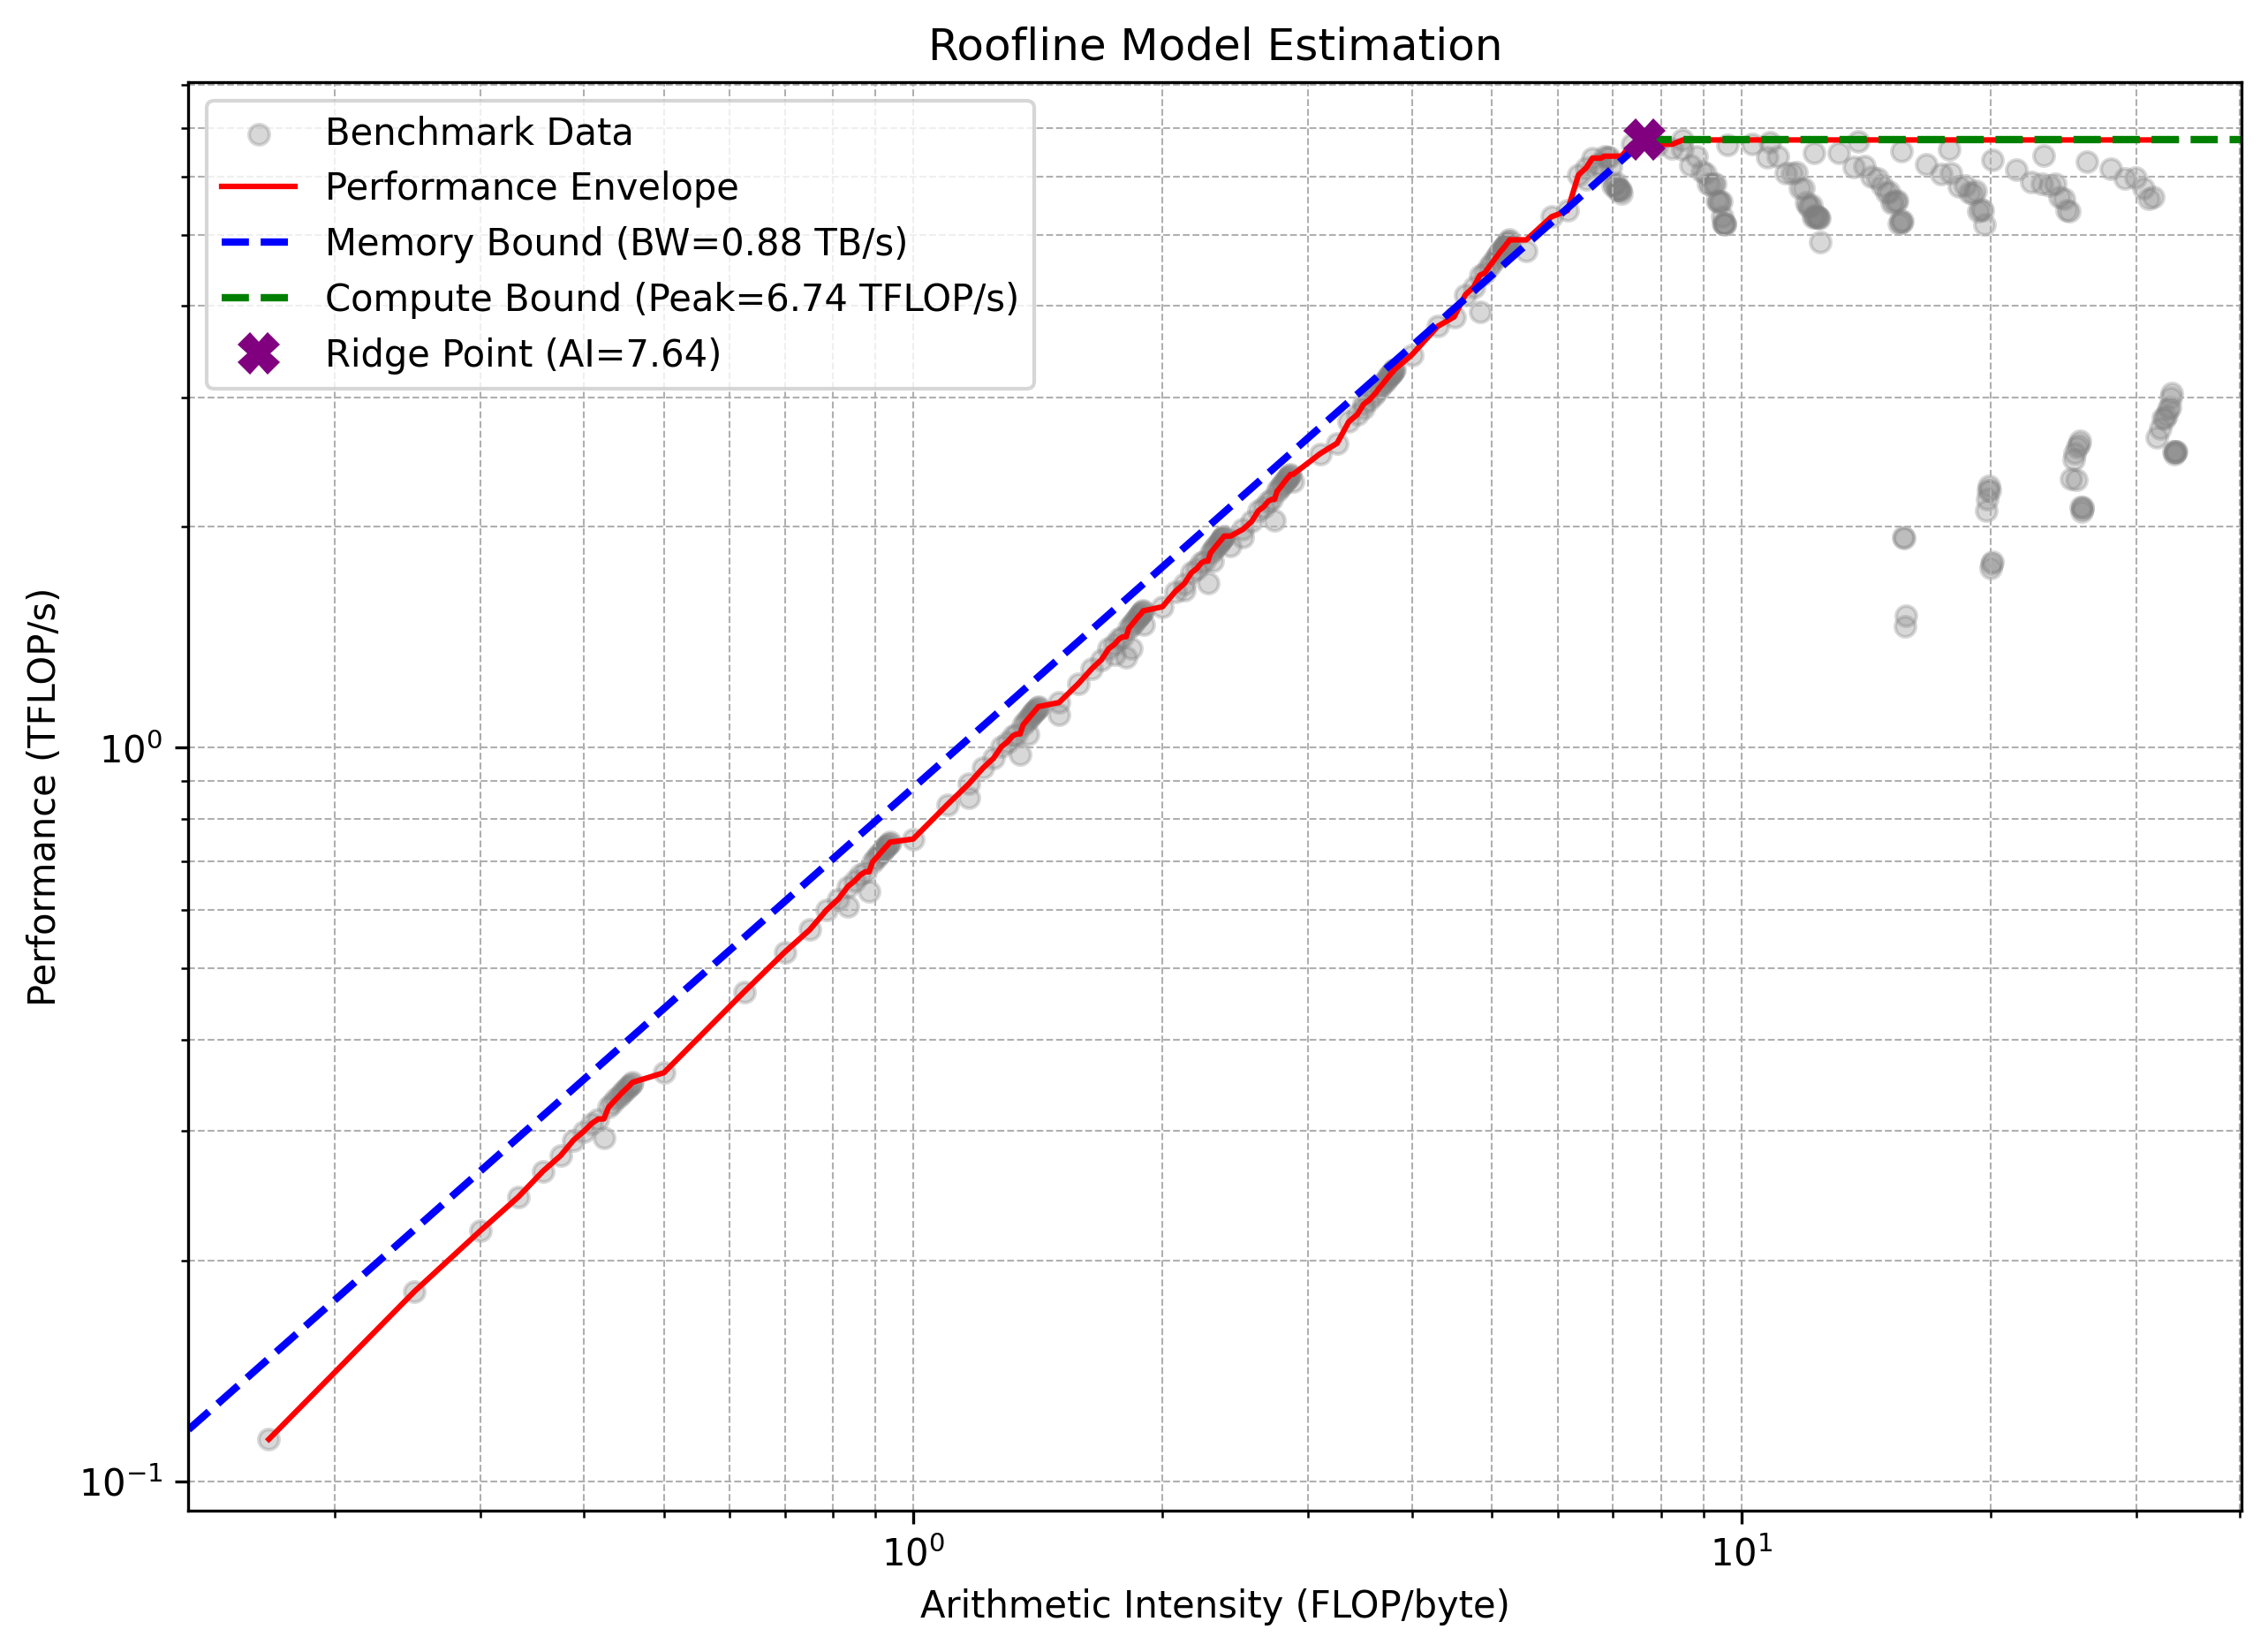


Peak TFLOP/s: 6.74 TFLOP/s
Memory Bandwidth: 0.88 TB/s
Ridge Point AI: 7.64 FLOP/byte



In [11]:
peak_tflops, memory_bw, ridge_point_ai = estimate_roofline(
  [v.arithmetic_intensity for v in vector_flops.values()],
  [v.tflops for v in vector_flops.values()],
)
print(f"""
Peak TFLOP/s: {peak_tflops:.2f} TFLOP/s
Memory Bandwidth: {memory_bw:.2f} TB/s
Ridge Point AI: {ridge_point_ai:.2f} FLOP/byte
""")

In [12]:
print(f"Published HBM bandwidth: {tpu_spec.hbm_bandwidth / 1e12:.2f} TB/s")

Published HBM bandwidth: 0.82 TB/s


We estimate that the HBM bandwidth is 0.88 TB/s from experiments, which is close!
We also see that the performance of the VPU (the vector processing unit of the
TPU) is ~6.74 TFLOP/s, much slower than the MXU (197 TFLOP/s).

# Matrix roofline

In [4]:
def measure_matmul_flops(matrix_size: int):
  NUM_ITERS = 100
  num_matrices = int(1 * 1024 * 1024 * 1024 // (matrix_size * matrix_size))
  a = torch.randn(num_matrices, matrix_size, matrix_size, dtype=torch.bfloat16, requires_grad=False, device=xm.xla_device())
  b = torch.randn(num_matrices, matrix_size, matrix_size, dtype=torch.bfloat16, requires_grad=False, device=xm.xla_device())
  torch_xla.sync()
  
  # Measure in a loop
  times = []
  for i in range(NUM_ITERS):
    torch_xla.sync(wait=True)
    result = torch.einsum('bxy,byz->bxz', a, b)
    start = time.time()
    torch_xla.sync()
    result = xm.unlazy([result])
    end = time.time()
    times.append(end - start)
  
  run_time = float(np.median(times))
  flops = 2 * matrix_size * matrix_size * matrix_size * num_matrices
  bytes_transferred = 3 * matrix_size * matrix_size * num_matrices * 2  # 2 bytes per BF16
  
  return BenchmarkResult(
    flops=flops / run_time,
    arithmetic_intensity=flops / bytes_transferred,
  )

In [9]:
import gc
matmul_flops = {}
for matrix_size in [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]:
  matmul_flops[matrix_size] = measure_matmul_flops(matrix_size)
  print(f"matmul_flops[{matrix_size}] = {matmul_flops[matrix_size]}")
  gc.collect()

matmul_flops[128] = 28.9897 TFLOP/s, 42.6667 FLOPS/byte
matmul_flops[256] = 57.9074 TFLOP/s, 85.3333 FLOPS/byte
matmul_flops[512] = 95.2070 TFLOP/s, 170.6667 FLOPS/byte
matmul_flops[1024] = 166.8121 TFLOP/s, 341.3333 FLOPS/byte
matmul_flops[2048] = 174.8482 TFLOP/s, 682.6667 FLOPS/byte
matmul_flops[4096] = 182.5367 TFLOP/s, 1365.3333 FLOPS/byte
matmul_flops[8192] = 186.5937 TFLOP/s, 2730.6667 FLOPS/byte
matmul_flops[16384] = 188.3139 TFLOP/s, 5461.3333 FLOPS/byte
matmul_flops[32768] = 190.7949 TFLOP/s, 10922.6667 FLOPS/byte


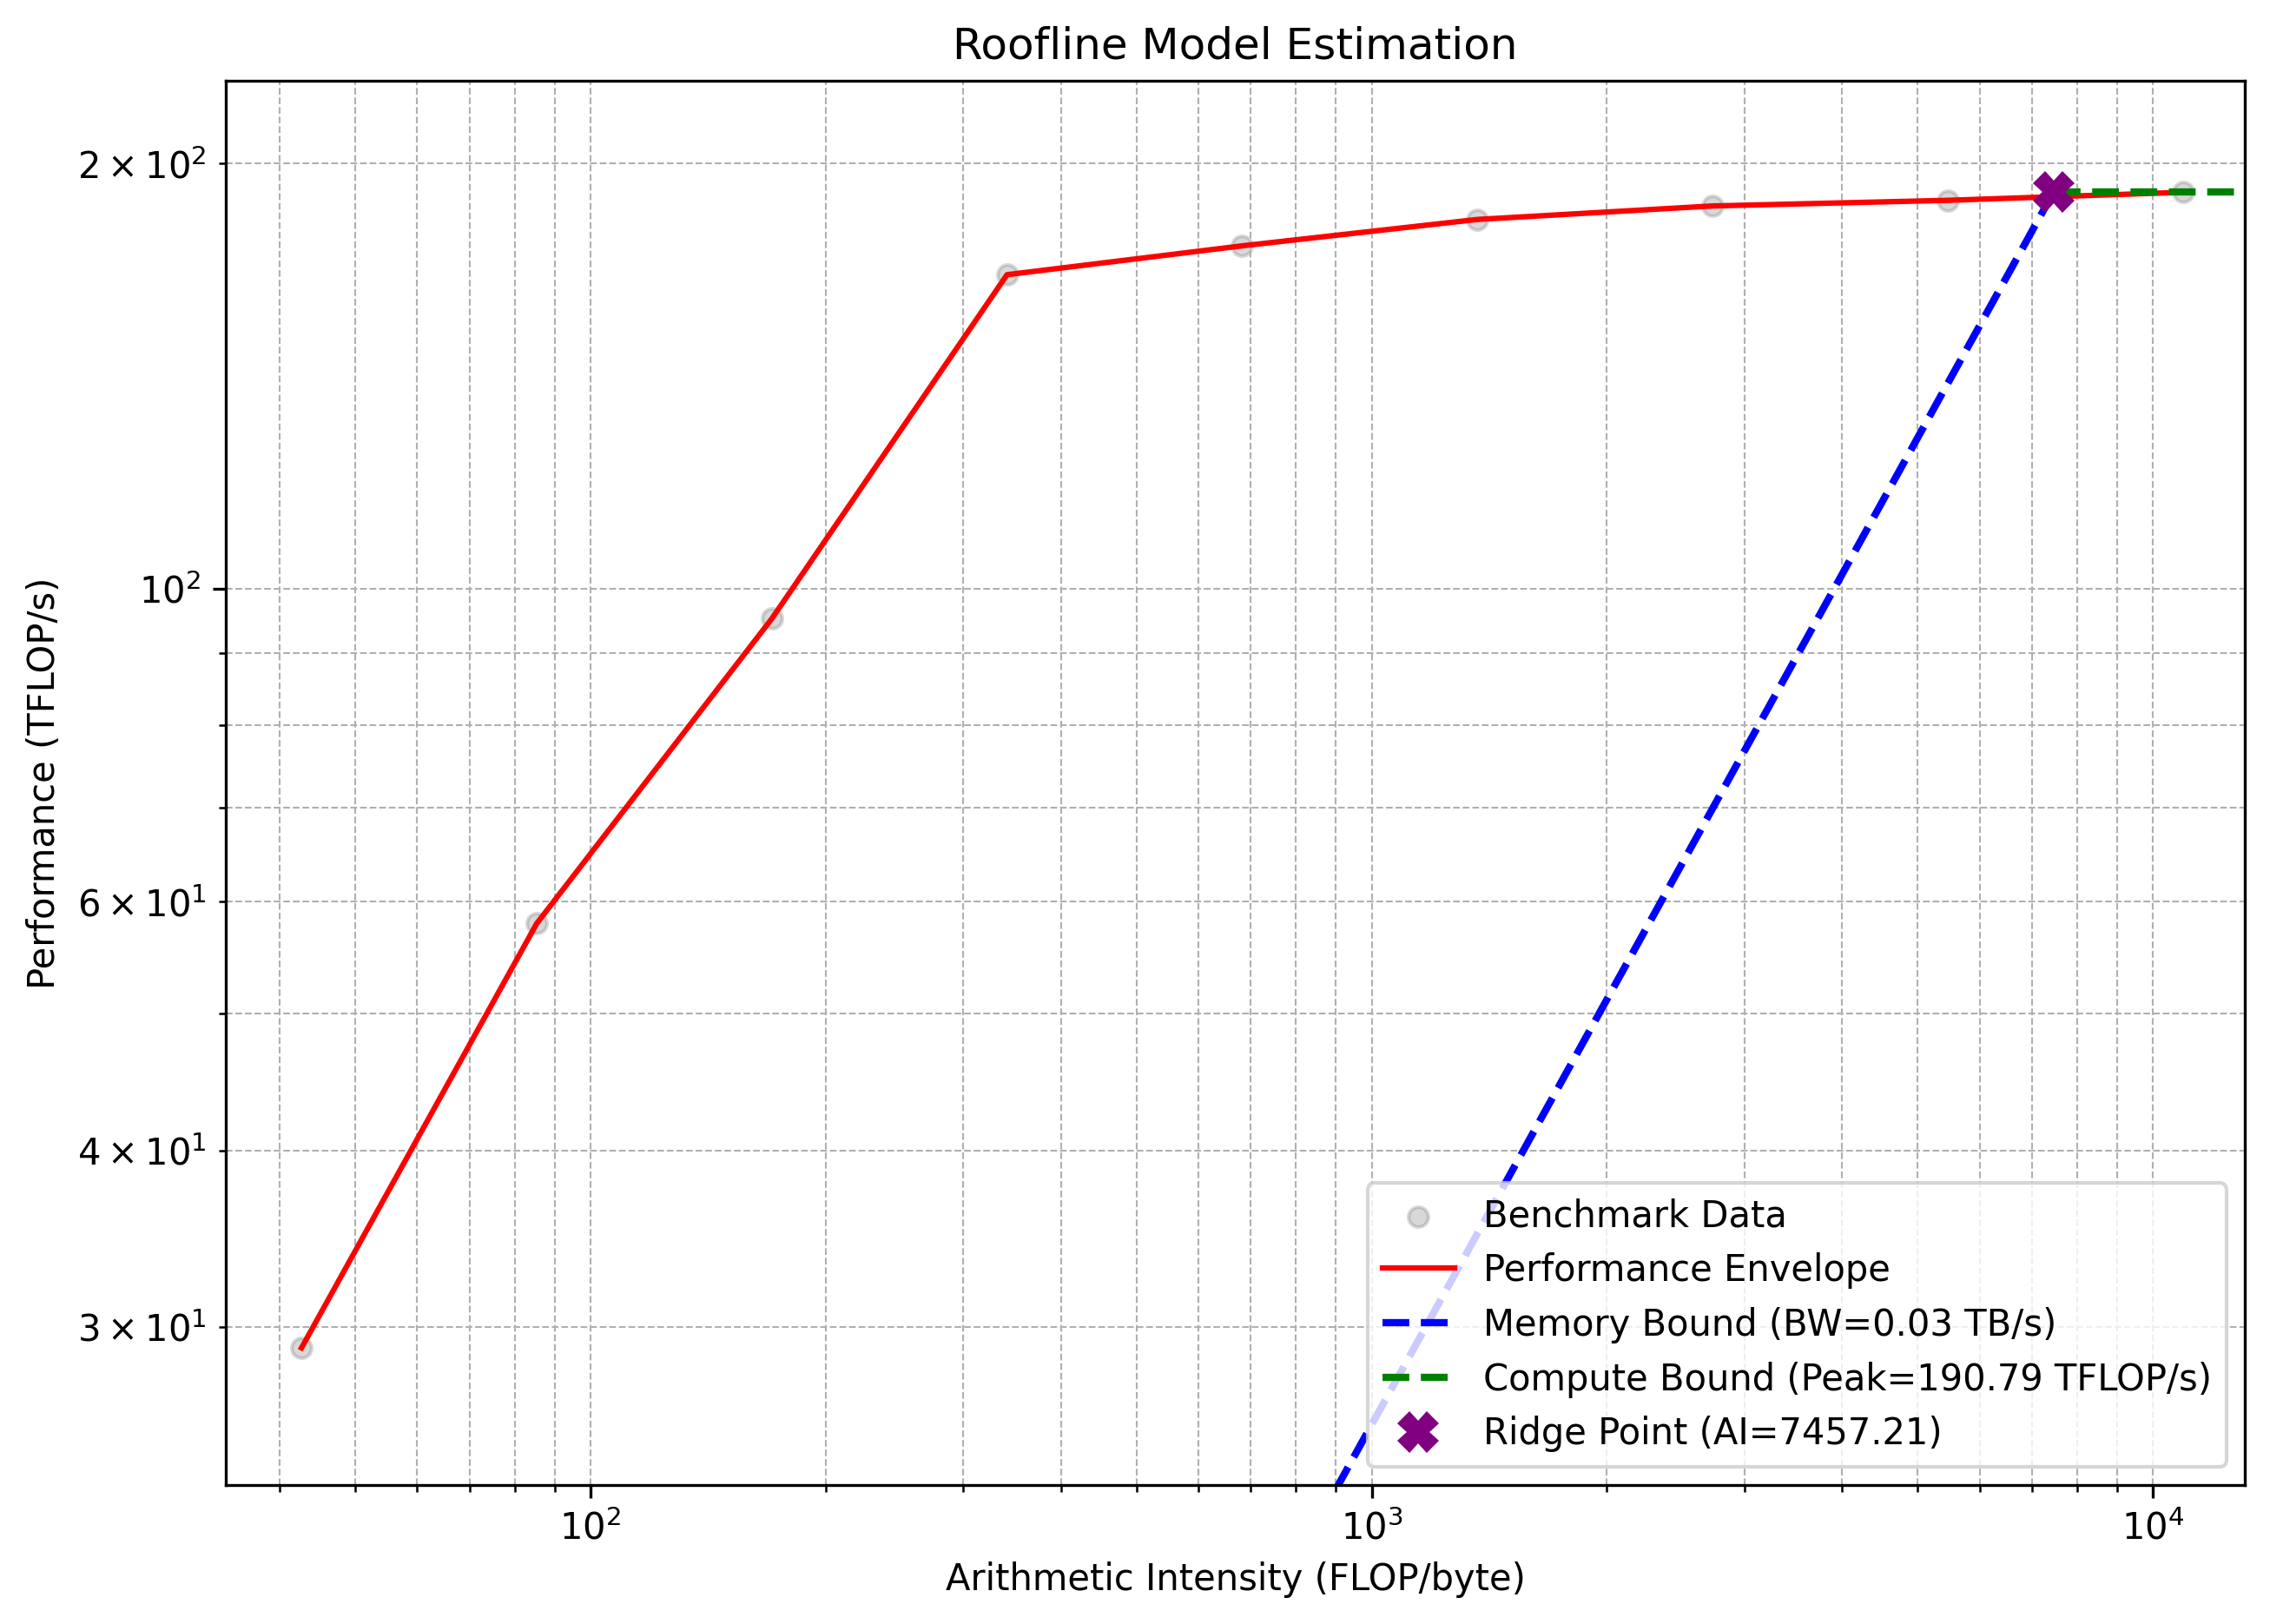


Peak TFLOP/s: 190.79 TFLOP/s
Memory Bandwidth: 0.03 TB/s
Ridge Point AI: 7457.21 FLOP/byte

Published MXU FLOPS: 197.00 TFLOP/s
Published HBM bandwidth: 0.82 TB/s



In [10]:
peak_tflops, memory_bw, ridge_point_ai = estimate_roofline(
  [v.arithmetic_intensity for v in matmul_flops.values()],
  [v.tflops for v in matmul_flops.values()],
)
print(f"""
Peak TFLOP/s: {peak_tflops:.2f} TFLOP/s
Memory Bandwidth: {memory_bw:.2f} TB/s
Ridge Point AI: {ridge_point_ai:.2f} FLOP/byte

Published MXU FLOPS: {tpu_spec.mxu_flops / 1e12:.2f} TFLOP/s
Published HBM bandwidth: {tpu_spec.hbm_bandwidth / 1e12:.2f} TB/s
""")